In [1]:
# %load_ext autoreload
# %autoreload 1
# %aimport utilsLoaders
# %aimport feats_arm_rom


In [2]:
from pathlib import Path

import pandas as pd # also openpyxl for xlsx files
import numpy as np
import scipy.signal as ss
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.spatial import ConvexHull

from tqdm.auto import tqdm, trange

from utilsLoaders import read_trc, read_mot
# import ocfeats

# gdrive = Path('/Volumes/GoogleDrive-112026393729621442608')
gdrive = Path('/Users/psr/Library/CloudStorage/GoogleDrive-paru@stanford.edu')
datadir = gdrive / 'My Drive/NMBL Lab/opencap_nmd/data/2023-05_dhd'

def get_trc_fpath(sid, trial):
    return datadir / f'opencap_data/{sid}/' \
        f'MarkerData/PostAugmentation/{trial}/{trial}.trc'

def get_mot_fpath(sid, trial):
    return datadir / f'opencap_data/{sid}/' \
        f'OpenSimData/Kinematics/{trial}.mot'

def get_sto_fpath(sid, trial):
    return datadir / f'opencap_data/{sid}/' \
        f'OpenSimData/Dynamics/{trial}_shoulder.sto'

def get_model_path(sid):
    model_dir = datadir / f'opencap_data/{sid}/OpenSimData/Model/'
    return list(mdir.glob('*.osim'))[0]

    

In [3]:
# colorblind friendly palette
from cycler import cycler
cp = ["#172A5A", "#FF7171", "#227567", "#34BAEA", "#F9D466", ]
plt.rcParams['axes.prop_cycle'] = cycler(color=cp)

# set default font
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Open Sans', 'Arial']

# automatically despine
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

# set defualt DPI
plt.rcParams['figure.dpi'] = 72



In [4]:
df_session = pd.read_excel(datadir / 'session_info.xlsx', )
df_trial = pd.read_excel(datadir / 'trial_info.xlsx')
df_part = pd.read_excel(datadir / 'participant_info.xlsx')


/Users/psr/opt/anaconda3/envs/sci/lib/python3.10/site-packages/openpyxl/worksheet/_read_only.py:81: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


In [5]:
# pid = 'p014'
pid = 'p036'
# pid = 'p060'
# pid = 'p093'
trial_clean = 'arm_rom'

df_temp = df_trial[df_trial.trial_clean == trial_clean]
df_temp = df_temp[df_temp.pid == pid]
um = df_temp.sample(1).iloc[0]
pid, sid, trial = um[['pid', 'sid', 'trial']]
print(pid)

fps, markers, xyz = read_trc(get_trc_fpath(sid, trial))


p036


In [6]:
markers

array(['Neck', 'RShoulder', 'RElbow', 'RWrist', 'LShoulder', 'LElbow',
       'LWrist', 'midHip', 'RHip', 'RKnee', 'RAnkle', 'LHip', 'LKnee',
       'LAnkle', 'LBigToe', 'LSmallToe', 'LHeel', 'RBigToe', 'RSmallToe',
       'RHeel', 'r.ASIS_study', 'L.ASIS_study', 'r.PSIS_study',
       'L.PSIS_study', 'r_knee_study', 'r_mknee_study', 'r_ankle_study',
       'r_mankle_study', 'r_toe_study', 'r_5meta_study', 'r_calc_study',
       'L_knee_study', 'L_mknee_study', 'L_ankle_study', 'L_mankle_study',
       'L_toe_study', 'L_calc_study', 'L_5meta_study', 'r_shoulder_study',
       'L_shoulder_study', 'C7_study', 'r_thigh1_study', 'r_thigh2_study',
       'r_thigh3_study', 'L_thigh1_study', 'L_thigh2_study',
       'L_thigh3_study', 'r_sh1_study', 'r_sh2_study', 'r_sh3_study',
       'L_sh1_study', 'L_sh2_study', 'L_sh3_study', 'RHJC_study',
       'LHJC_study', 'r_lelbow_study', 'r_melbow_study', 'r_lwrist_study',
       'r_mwrist_study', 'L_lelbow_study', 'L_melbow_study',
       'L_lwrist

### Reachable Workspace Right

In [43]:
from scipy.spatial.transform import Rotation as R
from numpy.linalg import norm
from scipy.spatial import ConvexHull

from feats_arm_rom import workspace_right

import plotly.express as px

out = xyz.copy()
rs = out[:,np.argmax(markers=='r_shoulder_study'),:]
origin = rs.reshape((rs.shape[0], 1, rs.shape[1]))
origin = np.broadcast_to(origin, xyz.shape)
out -= origin

rs = out[:,np.argmax(markers=='r_shoulder_study'),:]
ls = out[:,np.argmax(markers=='L_shoulder_study'),:]

df_temp = pd.DataFrame(ls-rs, columns=['x', 'y', 'z'])
fig = px.line_3d(df_temp, x='x', y='z', z='y',
                 width=600, height=600,
                 template='simple_white',
                 color_discrete_sequence=['rgba(255,0,0,0.5)'])

for i in range(out.shape[0]):
    vec = (ls-rs)[i,:]
    roty = np.arctan(vec[2] / vec[0])
    rotz = np.arctan(vec[1] / norm(vec[[0,2]]))
    rot = R.from_euler('yz', [roty, rotz])
    out[i,:,:] = rot.apply(out[i,:,:])


ls = out[:,np.argmax(markers=='L_shoulder_study'),:]

df_temp = pd.DataFrame(ls, columns=['x', 'y', 'z'])
fig.add_traces(list(
    px.line_3d(df_temp, x='x', y='z', z='y',
               color_discrete_sequence=['rgba(0,0,255,0.5)']).select_traces()
))

# re = out[:,np.argmax(markers=='r_melbow_study'),:]
rw = out[:,np.argmax(markers=='r_mwrist_study'),:]
rw[:,0] = rw[:,0].clip(0, None)
right_range = rw.copy()

arm_len = np.max(norm(rw, axis=1))

ch = ConvexHull(rw)
rewo_area = ch.area / (3 * np.pi * arm_len**2) # hemisphere area
rewo_sphere = ch.volume / (1/3 * np.pi * arm_len**3) # hemisphere volume
rewo_cube = np.product(rw.ptp(axis=0)) / (4*arm_len**3) # cuboid volume
print(rewo_area, rewo_sphere, rewo_cube)

df_temp = pd.DataFrame(rw, columns=['x', 'y', 'z'])
fig.add_traces(list(
    px.line_3d(df_temp, x='x', y='z', z='y',
               color_discrete_sequence=['rgba(50,100,50,0.5)']).select_traces()
))

rw, rewo_area, rewo_sphere, rewo_cube = \
    workspace_right(xyz[:,np.argmax(markers=='r_shoulder_study'),:],
                          xyz[:,np.argmax(markers=='L_shoulder_study'),:],
                          xyz[:,np.argmax(markers=='r_mwrist_study'),:], arm_len)
print(rewo_area, rewo_sphere, rewo_cube)

df_temp = pd.DataFrame(rw, columns=['x', 'y', 'z'])
fig.add_traces(list(
    px.line_3d(df_temp, x='x', y='z', z='y',
               color_discrete_sequence=['rgba(0,0,0,0.5)']).select_traces()
))

fig.add_traces(list(
    px.scatter_3d(pd.DataFrame([[0,0,0]], columns=['x', 'y', 'z']),
                  x='x', y='y', z='z').select_traces()
))
fig.update_layout(margin=dict(b=25, t=25, l=25, r=25))
fig.update_layout(scene_aspectmode='data')
fig.show()


0.20756976696614982 0.1809479434020761 0.15240648915315427
0.20756976696614976 0.1809479434020757 0.1524064891531543


### Reachable Workspace Left

In [42]:
from scipy.spatial.transform import Rotation as R
from numpy.linalg import norm
from scipy.spatial import ConvexHull

import plotly.express as px

out = xyz.copy()
ls = out[:,np.argmax(markers=='L_shoulder_study'),:]
origin = ls.reshape((ls.shape[0], 1, ls.shape[1]))
origin = np.broadcast_to(origin, out.shape)
out -= origin

rs = out[:,np.argmax(markers=='r_shoulder_study'),:]
# ls = out[:,np.argmax(markers=='L_shoulder_study'),:]

df_temp = pd.DataFrame(rs, columns=['x', 'y', 'z'])
fig = px.line_3d(df_temp, x='x', y='z', z='y',
                 width=600, height=600,
                 template='simple_white',
                 color_discrete_sequence=['rgba(255,0,0,0.5)'])

for i in range(out.shape[0]):
    vec = rs[i,:]
    roty = np.arctan(vec[2] / vec[0])
    rotz = np.arctan(vec[1] / norm(vec[[0,2]]))
    rot = R.from_euler('yz', [roty, -rotz]) # negative rotz
    out[i,:,:] = rot.apply(out[i,:,:])

rs = out[:,np.argmax(markers=='r_shoulder_study'),:]

df_temp = pd.DataFrame(rs, columns=['x', 'y', 'z'])
fig.add_traces(list(
    px.line_3d(df_temp, x='x', y='z', z='y',
               color_discrete_sequence=['rgba(0,0,255,0.5)']).select_traces()
))

lw = out[:,np.argmax(markers=='L_mwrist_study'),:]

lw[:,0] = lw[:,0].clip(None, 0)
left_range = lw.copy()

# arm_len = np.median(norm(rw))
# arm_len = np.percentile(norm(rw, axis=1), 90)
arm_len = np.max(norm(lw, axis=1))

ch = ConvexHull(lw)
rewo_area = ch.area / (3 * np.pi * arm_len**2) # hemisphere area
rewo_sphere = ch.volume / (1/3 * np.pi * arm_len**3) # hemisphere volume
rewo_cube = np.product(lw.ptp(axis=0)) / (4*arm_len**3) # cuboid volume
print(rewo_area, rewo_sphere, rewo_cube)

df_temp = pd.DataFrame(lw, columns=['x', 'y', 'z'])
fig.add_traces(list(
    px.line_3d(df_temp, x='x', y='z', z='y',
               color_discrete_sequence=['rgba(50,100,50,0.5)']).select_traces()
))

xyz_flip = xyz.copy()
xyz_flip[:,:,0] *= -1
ls = xyz_flip[:,np.argmax(markers=='L_shoulder_study'),:]
rs = xyz_flip[:,np.argmax(markers=='r_shoulder_study'),:]
lw = xyz_flip[:,np.argmax(markers=='L_mwrist_study'),:]
lw, rewo_area, rewo_sphere, rewo_cube = workspace_right(ls, rs, lw, arm_len)
lw[:,0] *= -1
print(rewo_area, rewo_sphere, rewo_cube)

df_temp = pd.DataFrame(lw, columns=['x', 'y', 'z'])
fig.add_traces(list(
    px.line_3d(df_temp, x='x', y='z', z='y',
               color_discrete_sequence=['rgba(0,0,0,0.5)']).select_traces()
))

fig.add_traces(list(
    px.scatter_3d(pd.DataFrame([[0,0,0]], columns=['x', 'y', 'z']),
                  x='x', y='y', z='z').select_traces()
))

fig.update_layout(margin=dict(b=25, t=25, l=25, r=25))
fig.update_layout(scene_aspectmode='data')
fig.show()


0.1748046628748178 0.13761881804348952 0.11917602957539368
0.17480466287481786 0.13761881804348933 0.11917602957539368


### Other

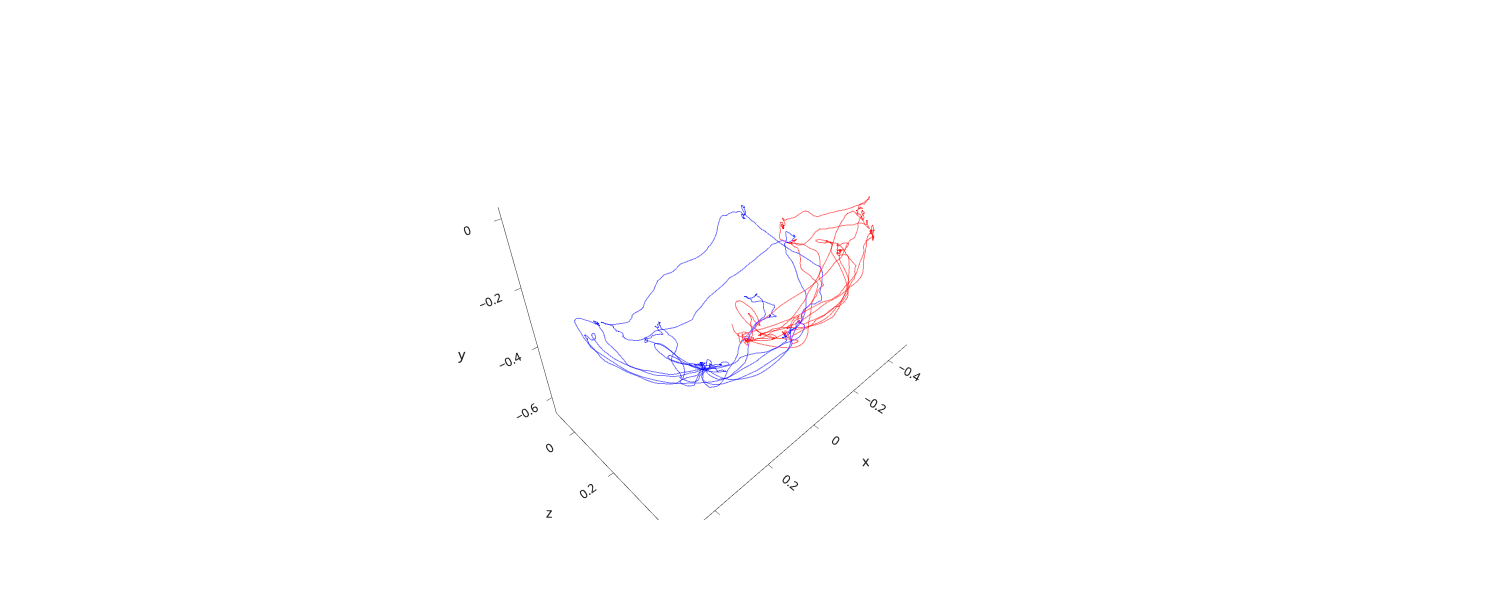

In [15]:
df_temp = pd.DataFrame(left_range, columns=['x', 'y', 'z'])
fig = px.line_3d(df_temp, x='x', y='z', z='y',
                 width=600, height=600,
                 template='simple_white',
                 color_discrete_sequence=['rgba(255,0,0,0.5)'])

df_temp = pd.DataFrame(right_range, columns=['x', 'y', 'z'])
fig.add_traces(list(
    px.line_3d(df_temp, x='x', y='z', z='y',
               color_discrete_sequence=['rgba(0,0,255,0.5)']).select_traces()
))


In [ ]:

# import plotly.express as px

# def plotlyify(rw, lw, rs, ls, saveto):
#     df_temp = pd.DataFrame(rw, columns=['x', 'y', 'z'])
#     fig = px.line_3d(df_temp, x='x', y='z', z='y',
#                      width=600, height=600,
#                      template='simple_white',
#                      color_discrete_sequence=np.array(cp)[[0,1]])
    
#     df_temp = pd.DataFrame(lw, columns=['x', 'y', 'z'])
#     fig.add_traces(
#         list(px.line_3d(df_temp, x='x', y='z', z='y',
#                         color_discrete_sequence=np.array(cp)[[1,2]]).select_traces())
#     )
    
#     df_temp = pd.DataFrame(rs, columns=['x', 'y', 'z'])
#     fig.add_traces(
#         list(px.line_3d(df_temp, x='x', y='z', z='y',
#                         color_discrete_sequence=['black']).select_traces())
#     )
    
#     df_temp = pd.DataFrame(ls, columns=['x', 'y', 'z'])
#     fig.add_traces(
#         list(px.line_3d(df_temp, x='x', y='z', z='y',
#                         color_discrete_sequence=['black']).select_traces())
#     )
    
#     fig.update_layout(margin=dict(b=25, t=25, l=25, r=25))
#     fig.update_layout(scene_aspectmode='cube')
#     fig.write_image(saveto)
#     # fig.show()

# for pid in df_trial.pid.unique():
#     df_temp = df_trial[df_trial.trial_clean == trial_clean]
#     df_temp = df_temp[df_temp.pid == pid]
#     um = df_temp.sample(1).iloc[0]
#     pid, sid, trial = um[['pid', 'sid', 'trial']]

#     outpath = Path(f'arm_rom_imgs/{pid}.png')
#     if outpath.exists():
#         continue

#     fps, markers, xyz = read_trc(get_trc_fpath(sid, trial))
    
#     # REACHABLE WORKSPACE
    
#     rs = xyz[:,np.argmax(markers=='r_shoulder_study'),:]
#     ls = xyz[:,np.argmax(markers=='L_shoulder_study'),:]
#     rw = xyz[:,np.argmax(markers=='r_mwrist_study'),:]
#     lw = xyz[:,np.argmax(markers=='L_mwrist_study'),:]

#     plotlyify(rw, lw, rs, ls, outpath)
    

In [41]:
df_temp = pd.DataFrame({'marker': markers, 'x':xyz[0,:,0], 'y':xyz[0,:,1], 'z':xyz[0,:,2]})
fig = px.scatter_3d(df_temp, x='x', y='z', z='y', hover_data='marker',
                    width=600, height=600,
                    template='simple_white',
                    color_discrete_sequence=['rgba(255,0,0,0.5)'])
fig.update_layout(margin=dict(b=25, t=25, l=25, r=25))
fig.update_layout(scene_aspectmode='data')
fig.show()
